In [1]:
import numpy as np 

import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

/project/amp/akwilson/testdata/ENTER/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/project/amp/akwilson/testdata/ENTER/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import pandas
import numpy as np
import datetime as dt

In [3]:
import xarray as xr
import numpy as np
# function that does the counting logic
def incrementer(current_value, previous_value, last_id):
    # function that does the counting logic
    if current_value == 1:
        if previous_value > 0:
            return last_id  # continue current event
        else:
            return last_id + 1  # start a new event
    else:
        return 0  # non-event

In [4]:
vincrementer = np.vectorize(incrementer)
# the testing data set:
# "by_coords" for newest version of xarray
# the quantiles:
ds_q = xr.open_dataset("/project/amp/brianpm/TemperatureExtremes/Derived/CPC_tmax_dayofyear_quantiles_15daywindow_c20190622.nc")

In [6]:
ds = xr.open_mfdataset("/project/amp/akwilson/2006-2019/tmax.*.nc")
tmax = ds["tmax"]
ninety = ds_q["tmax"].sel(quantile=0.9)
# make 'dayofyear' be the coordinate variable for ninety
ninety = ninety.rename({"time": "dayofyear"})
ninety["dayofyear"] = np.arange(1, 367)


In [7]:
extreme_mask = np.where(tmax.groupby("time.dayofyear") >= ninety, 1, 0)
# get it into form of DataArray with coordinates
xmask = xr.DataArray(extreme_mask, coords=tmax.coords, dims=tmax.dims)

/project/amp/akwilson/testdata/ENTER/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


In [8]:
xcount = np.zeros((360, 720))


In [9]:
event_id = np.zeros(tmax.shape)
event_id[0, ...] = extreme_mask[0, ...]

In [10]:
for t in np.arange(1, len(tmax["time"])):
    event_id[t, ...] = vincrementer(xmask[t, ...], xmask[t - 1, ...], xcount)
    # increment xcount:
    # rule: if the current event_id is larger than the last time, it means we started a new event,
    #       so increment xcount, otherwise keep the current value.
    xcount = np.where(event_id[t, ...] > event_id[t - 1, ...], xcount + 1, xcount)

In [11]:
event_id_da = xr.DataArray(event_id, coords=tmax.coords, dims=tmax.dims)
event_id_da.name = "Event_ID"
event_id_da.attrs["long_name"] = "Event ID Number based on Tmax > 90th percentile"


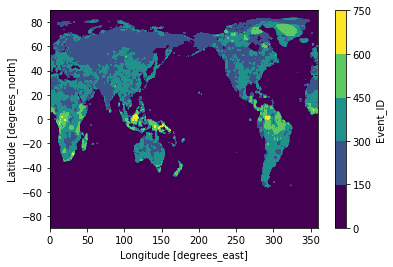

In [12]:
event_id_da.max(dim='time').plot.contourf()

In [18]:
event_id_da

<xarray.DataArray 'Event_ID' (time: 4874, lat: 360, lon: 720)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]])
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2019-05-06
Attributes:
    long_name:  Event ID Number based on Tmax > 90th percentile

In [16]:
event_id_da

<xarray.DataArray 'Event_ID' (time: 4874, lat: 360, lon: 720)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]])
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75
  * time     (time) datetime64[ns] 2006-01-01 2006-01-02 ... 2019-05-06
Attributes:
    long_name:  Event ID Number based on Tmax > 90th percentile

In [19]:
import numpy as np
import xarray as xr
import logging
logging.basicConfig(level=logging.INFO)

In [20]:
testing = False
test_sample_size = 5*366



#
# local function to define events/index/duration
#
def theloop(arr):
	# setup 
	out_event_size = arr.max()            # largest number of events -> defines output array size
	nz = arr.shape[1]                     # number of spatial points
	a = np.zeros((nz, out_event_size+1))  # +1 because we didn't include the zeros
	b = np.zeros((nz, out_event_size+1))
	c = np.zeros((nz, out_event_size+1))
	for loc in np.arange(nz):
		if loc % 1000 == 0:
			logging.info(f"We are up to location index {loc}")
		loc_ids, init_ndx, duration = np.unique(
	    	arr[:,loc], return_index=True, return_counts=True)
		n_loc = len(loc_ids)
		a[loc, 0:n_loc] = loc_ids
		b[loc, 0:n_loc] = init_ndx
		c[loc, 0:n_loc] = duration
		# a: the individual id numbers for events at each point
		# b: the index of the first occurrence of each event (initial time)
		# c: the number of values with the id value, i.e., the duration in days
	return a,b,c

In [21]:
fil = (
    "/project/amp/brianpm/TemperatureExtremes/Derived/CPC_tmax_90pct_event_detection.nc"
)
ds = xr.open_dataset(fil)
logging.info("ds is defined.")
if testing:
	events = ds["Event_ID"].isel(time=slice(0,test_sample_size))
else:
	events = ds["Event_ID"]

logging.info("events array defined.")

INFO:root:ds is defined.
INFO:root:events array defined.


In [28]:
eventnum = event_id_da.max(dim="time")
print(eventnum)


<xarray.DataArray 'Event_ID' (lat: 360, lon: 720)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75


In [29]:
data = event_id_da.sel(lat=43.75, lon=275.25, method='nearest').values
mynums = set(data)
duration = []
for i in mynums:
    tmp = data[data == i]
    duration.append(len(tmp))
    

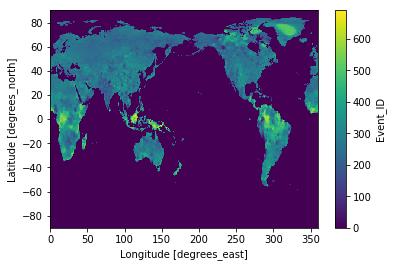

In [35]:
eventnum.plot()
projection=ccrs.PlateCarree()

In [36]:
np.sum(np.array(duration) == 3)

31